In [35]:
setwd("/Users/micaelawiseman/PhD/Thesis/Winterlight")
source("/Users/micaelawiseman/PhD/Thesis/Winterlight/Code/WL_helperfuncs.r", encoding = "UTF-8")

Load and clean data

In [51]:
# Read and preprocess speech datasets
library(readxl)
library(dplyr)
library(readr)
library(tidyr)

# Read datasets
# Read and preprocess speech data
WL <- speech_read_and_preprocess("~/PhD/Thesis/Data/WINTERLIGHT_Sunnybrook_rTMS_2023_11_03.csv")
WL_2 <- speech_read_and_preprocess("~/PhD/Thesis/Data/WINTERLIGHT_Sunnybrook_rTMSremote_2023_11_03.csv")

# Apply filters
WL <- WL[grep("^(TMS|MDD|MFB|OCD)", WL$participant_external_id), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039" & WL_2$session_label %in% c("V2", "V3", "V4")), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039b" & WL_2$session_label == "V1"), ]
WL_2$participant_external_id[WL_2$session_label %in% c("V2", "V3") & WL_2$participant_external_id == "TMS039b"] <- "TMS039"

# Combine datasets
WL_combined <- rbind(WL, WL_2)

# Processing participant_group
WL_combined$participant_group <- factor(
  ifelse(
    grepl("(^CTC|C_CTC)", WL_combined$participant_external_id), "Control",
    ifelse(grepl("^(TMS|MDD|MFB)", WL_combined$participant_external_id), "MDD",
    ifelse(grepl("^(OCD)", WL_combined$participant_external_id), "OCD",
    "Other" 
    )
  )
))

# Exclude specific participants
WL_combined <- WL_combined[WL_combined$participant_external_id != "CTC036" &
    WL_combined$participant_external_id != "CTC004" &
    WL_combined$participant_external_id != "CTC006" &
    WL_combined$participant_external_id != "CTC017" &
    WL_combined$participant_external_id != "CTC030" &
    WL_combined$participant_external_id != "CTC039" &
    WL_combined$participant_external_id != "CTC043" &
    WL_combined$participant_external_id != "CTC045" &
    WL_combined$participant_external_id != "CTC053" &
    WL_combined$participant_external_id != "CTC052" &
    WL_combined$participant_external_id != "CTC058" &
    WL_combined$participant_external_id != "CTC058_new" &
    WL_combined$participant_external_id != "CTC023" &
    WL_combined$participant_external_id != "CTB001", ] ## Remove participants with high QIDS

# Remove participants with baseline data post TMS 
WL_combined <- WL_combined[!(WL_combined$participant_external_id == "TMS049" & WL_combined$session_label == "V1"), ]

# Define remote participants and assign testing location
remote_participants <- c(
    "CTC001", "CTC015", "CTC021", "CTC028", "CTC013", "CTC030",
    "CTC034", "CTC036", "CTC045", "TMS038")

# Function to identify CTC046 and higher
is_ctc046_or_higher <- function(id) {
  if (grepl("^CTC", id)) {
    # Extract the numeric part of the ID and check if it is 46 or higher
    num_part <- as.numeric(sub("^CTC", "", id))
    return(num_part >= 46)
  }
  FALSE
}

# Apply the function to all participants and get those that are CTC046 or higher
ctc046_or_higher <- sapply(WL_combined$participant_external_id, is_ctc046_or_higher)
additional_ctc <- WL_combined$participant_external_id[ctc046_or_higher]


# Function to identify TMS040 and higher
is_tms040_or_higher <- function(id) {
    if (grepl("^TMS", id)) {
        # Extract the numeric part of the ID and check if it is 46 or higher
        num_part <- as.numeric(sub("^TMS", "", id))
        return(num_part >= 40)
    }
    FALSE
}

# Apply the function to all participants and get those that are CTC046 or higher
tms040_or_higher <- sapply(WL_combined$participant_external_id, is_tms040_or_higher)
additional_tms <- WL_combined$participant_external_id[tms040_or_higher]

remote_participants <- c(remote_participants, additional_ctc, additional_tms)

WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% remote_participants, 
                                       "remote", "in-person")
WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% c("TMS052", "TMS053"), 
                                       "remote", WL_combined$testing_location)

                                 

# Replace values in session_label column
WL_combined$session_label <- gsub("Baseline", "V1", WL_combined$session_label)

# Read and process demographic data
demoMDD <- demo_read_and_process(1)
demoCTRL <- demo_read_and_process(2)

# Generate new column names
column_mapping <- setNames(
    # Old names
  c(paste0(rep(c("bl_", "2wk_", "4wk_"), each = 1), "qids_tot"),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 16), "qids_sr_", 1:16),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 8), "gad7_", 1:8),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 8), "gad7_tot")),
  # New names
  c(paste0("qids_total_", c("pre", "wk2", "wk4")),
    paste0("qids_", 1:16, "_", rep(c("pre", "wk2", "wk4"), each = 16)),
    paste0("gad7_", 1:8, "_", rep(c("pre", "wk2", "wk4"), each = 8)),
    paste0("gad7_total_", rep(c("pre", "wk2", "wk4"), each = 8)))
)

# Remove leading and trailing whitespaces from column names in demoCTRL
demoCTRL <- demoCTRL %>%
  rename_all(~trimws(.))

# Rename columns in demoCTRL
demoCTRL <- demoCTRL %>% rename(!!!column_mapping)

# Combine demographic datasets
demoMDD$dob_yr <- as.numeric(demoMDD$dob_yr)
demoCTRL$dob_yr <- as.numeric(demoCTRL$dob_yr)
demoALL <- bind_rows(demoMDD, demoCTRL)

# Merge relevant columns from demoALL into WL

WL_demo <- WL_combined %>% left_join(demoALL %>% select(participant_external_id, sex,
                                          age_screening,
                                          years_education,
                                          age_learned_english,
                                          first_language_english,
                                          starts_with("qids"),
                                          starts_with("gad7")))

# Read in psychiatry data
psych <- read_csv("~/PhD/Thesis/Data/Final_Consolidated_Psychiatry_Data.csv")

# Filter to match participant IDs in WL_demo
psych_filtered <- psych %>%
  filter(participant_external_id %in% WL_demo$participant_external_id)

# Merge the datasets based on "participant_external_id" and retain all columns
# Use full_join to include all participants from both datasets
WL_demo_psych <- full_join(psych_filtered %>% select(participant_external_id,
                                              starts_with("hamd17"),
                                              starts_with("qids"),
                                              starts_with("gad7")),
                           WL_demo,
                           by = "participant_external_id",
                           suffix = c("", ".psych"))

# Identify common columns (excluding "participant_external_id")
common_columns <- setdiff(intersect(names(WL_demo), names(psych_filtered)), "participant_external_id")

# Update NA values in WL_demo columns with values from psych where applicable
WL_demo_psych <- WL_demo_psych %>%
  mutate(across(all_of(common_columns), 
  ~ifelse(is.na(.), get(paste0(cur_column(), ".psych")), .)))

# Optionally, remove the extra columns if they are no longer needed
WL_demo_psych <- select(WL_demo_psych, -ends_with(".psych"))

# Check the structure of the final dataframe
str(WL_demo_psych)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Joining with `by = join_by(participant_external_id)`
Rows: 68 Columns: 976
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (71): participant_external_id, demographic_data_timestamp, demog_househ...
dbl (785): demog_gender, demog_sex, demog_age, demog_married, demog_children...
lgl (120): demog_gender_other, demog_sex_other, pretreatment_clinician_admin...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


tibble [1,081 x 1,146] (S3: tbl_df/tbl/data.frame)
 $ participant_external_id                                    : chr [1:1081] "TMS001" "TMS001" "TMS001" "TMS001" ...
 $ hamd17_1_pre                                               : num [1:1081] 4 4 4 4 4 4 4 4 4 4 ...
 $ hamd17_2_pre                                               : num [1:1081] 2 2 2 2 2 2 2 2 2 2 ...
 $ hamd17_3_pre                                               : num [1:1081] 0 0 0 0 0 0 0 0 0 0 ...
 $ hamd17_4_pre                                               : num [1:1081] 2 2 2 2 2 2 2 2 2 2 ...
 $ hamd17_5_pre                                               : num [1:1081] 0 0 0 0 0 0 0 0 0 0 ...
 $ hamd17_6_pre                                               : num [1:1081] 0 0 0 0 0 0 0 0 0 0 ...
 $ hamd17_7_pre                                               : num [1:1081] 3 3 3 3 3 3 3 3 3 3 ...
 $ hamd17_8_pre                                               : num [1:1081] 1 1 1 1 1 1 1 1 1 1 ...
 $ hamd17_9_pre         

Subset by task (journalling) and visit (baseline)

In [52]:
# Subset to look at journaling and baseline scores
WL_full_jou <-subset_by_task(WL_demo_psych, "journaling")
WL_full_jou_bl<-subset_by_visit(WL_full_jou, "V1")

str(WL_full_jou_bl)

tibble [154 x 1,146] (S3: tbl_df/tbl/data.frame)
 $ participant_external_id                                    : chr [1:154] "TMS001" "TMS001" "TMS002" "TMS002" ...
 $ hamd17_1_pre                                               : num [1:154] 4 4 3 3 3 3 3 3 4 4 ...
 $ hamd17_2_pre                                               : num [1:154] 2 2 0 0 1 1 3 3 2 2 ...
 $ hamd17_3_pre                                               : num [1:154] 0 0 4 4 2 2 2 2 2 2 ...
 $ hamd17_4_pre                                               : num [1:154] 2 2 1 1 1 1 0 0 2 2 ...
 $ hamd17_5_pre                                               : num [1:154] 0 0 0 0 1 1 2 2 0 0 ...
 $ hamd17_6_pre                                               : num [1:154] 0 0 2 2 2 2 2 2 0 0 ...
 $ hamd17_7_pre                                               : num [1:154] 3 3 3 3 4 4 3 3 3 3 ...
 $ hamd17_8_pre                                               : num [1:154] 1 1 0 0 1 1 0 0 1 1 ...
 $ hamd17_9_pre                    

Narrow down target demographic and speech variables and check missing 

In [53]:
# Categorizing variables into Clinical, Demographic, and Speech variables
demographic_variables <- c('sex', 'age_screening', 'participant_group', 'age_learned_english', 'testing_location','years_education',"first_language_english")
speech_variables <- c('fundamental_frequency_mean','fundamental_frequency_variance', 'intensity_mean_db','medium_pause_duration',
                    'speech_rate', 'sentiment_dominance', 'sentiment_valence',
                    'sentiment_arousal')

# Creating subsets of data based on these categories
clinical_data <- WL_full_jou_bl[, c("participant_external_id", "hamd17_total_pre")]
demographic_data <- WL_full_jou_bl[, c("participant_external_id", demographic_variables)]
speech_data <- WL_full_jou_bl[, c("participant_external_id", speech_variables)]

speech_missing <- analyze_missing_data(speech_data, "participant_external_id")
write.csv(speech_missing, "~/PhD/Thesis/Data/speech_missing.csv")


# For clinical data
clinical_missing <- analyze_missing_data(clinical_data, "participant_external_id")
write.csv(clinical_missing, "~/PhD/Thesis/Data/clinical_missing.csv")


# For demographic data
demographic_missing <- analyze_missing_data(demographic_data, "participant_external_id")
write.csv(demographic_missing, "~/PhD/Thesis/Data/demographic_missing.csv")

Linear models in MDD patients (with interaction term)

In [54]:
install.packages("dplyr")
install.packages("ggplot2")
install.packages("lmtest")

library(dplyr)
library(ggplot2)
library(lmtest)

WL_full_jou_bl$sex <- as.factor(WL_full_jou_bl$sex)
WL_full_jou_bl$testing_location <- as.factor(WL_full_jou_bl$testing_location)
WL_jou_bl_MDD <- WL_full_jou_bl %>% filter(participant_group == "MDD")
WL_jou_bl_MDD_feeling <- WL_jou_bl_MDD %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

results <- list()
plots <- list()

# Create a directory for the plots
plots_directory <- "~/PhD/Thesis/Plots/"
if (!dir.exists(plots_directory)) {
    dir.create(plots_directory)
}

for (s in speech_variables) {
    # Filter out observations where sex is NA
    filtered_data <- WL_jou_bl_MDD_feeling %>%
        filter(!is.na(sex), !is.na(!!as.symbol(s)), !is.na(hamd17_total_pre))
    
    # Linear regression with interaction term
    formula <- as.formula(paste("hamd17_total_pre ~", s, "* sex + age_screening + age_learned_english"))
    model <- lm(formula, data = filtered_data)
    
    # Model summary
    model_summary <- summary(model)
    
    # Store the summary result
    results[[paste(s, "hamd17_total_pre interaction", sep = "_")]] <- model_summary
    
    # Create a plot
    plot_name <- paste(s," hamd17_total_pre interaction_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = s, y = "hamd17_total_pre", color = "sex")) +
        geom_point(alpha = 0.6) +
        geom_smooth(method = "lm", se = FALSE, 
                    aes_string(group = "sex", color = "sex")) + 
    labs(title = paste(s, "X", "hamd17_total_pre", sep = " "),
         x = s, y = "hamd17_total_pre") +
    theme_minimal() +
    theme(plot.title = element_text(size = 17)) # smaller title

  # Save the plot
  file_name <- paste(plots_directory, "/", plot_name, ".png", sep = "")
  ggsave(file_name, plot, width = 6, height = 4, bg = "white")
}

print(plots)
print(results)



The downloaded binary packages are in
	/var/folders/0w/9q69h2j54flcw9syyjdzrb3m0000gn/T//Rtmpg1wGfT/downloaded_packages

The downloaded binary packages are in
	/var/folders/0w/9q69h2j54flcw9syyjdzrb3m0000gn/T//Rtmpg1wGfT/downloaded_packages

The downloaded binary packages are in
	/var/folders/0w/9q69h2j54flcw9syyjdzrb3m0000gn/T//Rtmpg1wGfT/downloaded_packages


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


list()
$`fundamental_frequency_mean_hamd17_total_pre interaction`

Call:
lm(formula = formula, data = filtered_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8855 -2.5063 -0.2933  1.4354  9.5474 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)  
(Intercept)                     12.60152    5.29727   2.379   0.0228 *
fundamental_frequency_mean       0.04800    0.02809   1.709   0.0961 .
sexM                            12.34997    7.26480   1.700   0.0978 .
age_screening                    0.02155    0.05065   0.425   0.6731  
age_learned_english             -0.05651    0.12056  -0.469   0.6421  
fundamental_frequency_mean:sexM -0.08694    0.05719  -1.520   0.1372  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.951 on 36 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.09299,	Adjusted R-squared:  -0.03298 
F-statistic: 0.7382 on 5 and 36 DF,  p-value: 

Linear models in MDD patients without interaction term

In [55]:
library(dplyr)
library(ggplot2)
library(lmtest)

results <- list()
plots <- list()
stats_df <- data.frame()  # Dataframe to store statistics
p_values_lms <- c()  # Vector to collect p-values

# Create a directory for the plots
plots_directory <- "~/PhD/Thesis/Plots/"
if (!dir.exists(plots_directory)) {
    dir.create(plots_directory)
}

for (s in speech_variables) {
    # Filter out observations where sex is NA
    filtered_data <- WL_jou_bl_MDD_feeling %>%
        filter(!is.na(sex), !is.na(!!as.symbol(s)), !is.na(hamd17_total_pre))
    
    # Linear regression without interaction term
    formula <- as.formula(paste("hamd17_total_pre ~", s, "+ sex + age_screening + age_learned_english"))
    model <- lm(formula, data = filtered_data)
    
    # Model summary
    model_summary <- summary(model)
    
    # Store the summary result
    results[[paste(s, "hamd17_total_pre", sep = "_")]] <- model_summary
    
    # Extract coefficients and p-values
    coefs <- summary(model)$coefficients
    p_values_lms<- c(p_values_lms, coefs[2, "Pr(>|t|)"])  # Collect p-values
    
    # Create a summary stats row
    stats_row <- data.frame(variable = s, 
                            estimate = coefs[2, "Estimate"], 
                            std_error = coefs[2, "Std. Error"], 
                            statistic = coefs[2, "t value"], 
                            p_value = coefs[2, "Pr(>|t|)"])
    stats_df <- rbind(stats_df, stats_row)  # Append to the stats dataframe

    # Create and save plots
    plot_name <- paste(s, "hamd17_total_pre_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = s, y = "hamd17_total_pre")) +
        geom_point(alpha = 0.6) +
        geom_smooth(method = "lm", se = FALSE) + 
        labs(title = paste(s, "vs", "hamd17_total_pre"),
             x = s, y = "hamd17_total_pre") +
        theme_minimal() +
        theme(plot.title = element_text(size = 17))
    file_name <- paste(plots_directory, "/", plot_name, ".png", sep = "")
    ggsave(file_name, plot, width = 6, height = 4, bg = "white")
}

# Print and save results
print(plots)
print(results)
write.csv(stats_df, file = paste(plots_directory, "/SOBPS_LMs_summary_statistics.csv", sep = ""))



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


list()
$fundamental_frequency_mean_hamd17_total_pre

Call:
lm(formula = formula, data = filtered_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2145 -2.8626 -0.2087  1.9179  9.3101 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                17.203917   4.423498   3.889 0.000403 ***
fundamental_frequency_mean  0.025715   0.024385   1.055 0.298483    
sexM                        1.648712   1.830457   0.901 0.373568    
age_screening              -0.003478   0.048742  -0.071 0.943501    
age_learned_english        -0.038182   0.122058  -0.313 0.756175    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.021 on 37 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.03475,	Adjusted R-squared:  -0.0696 
F-statistic: 0.333 on 4 and 37 DF,  p-value: 0.854


$fundamental_frequency_variance_hamd17_total_pre

Call:
lm(formula = formula, data = filter

ANCOVAs by group controlling for sex

                        Variable     F_Value        Pr_F  Df
1     fundamental_frequency_mean 4.995829690 0.029488844 1/1
2 fundamental_frequency_variance 1.412954199 0.239673747 1/1
3              intensity_mean_db 0.001081009 0.973890344 1/1
4          medium_pause_duration 4.332719304 0.042054125 1/1
5                    speech_rate 7.681922164 0.007595979 1/1
6            sentiment_dominance 3.863331955 0.054409563 1/1
7              sentiment_valence 5.232256444 0.026041949 1/1
8              sentiment_arousal 8.015476394 0.006465883 1/1
  Partial_Eta_Squared     Mean_MDD       SD_MDD Mean_Control   SD_Control
1        8.326962e-02  137.9121898   36.2801279  173.6192293   35.4671521
2        2.504663e-02 3164.8306959 2809.8221200 3163.6266027 2268.2896424
3        1.965433e-05   54.8127354    5.1011963   55.2521216    3.1669611
4        7.302411e-02    0.4134119    0.2011780    0.3007412    0.1986712
5        1.225540e-01   96.6805580   49.9083112  137.6435792   35.8476318
6      

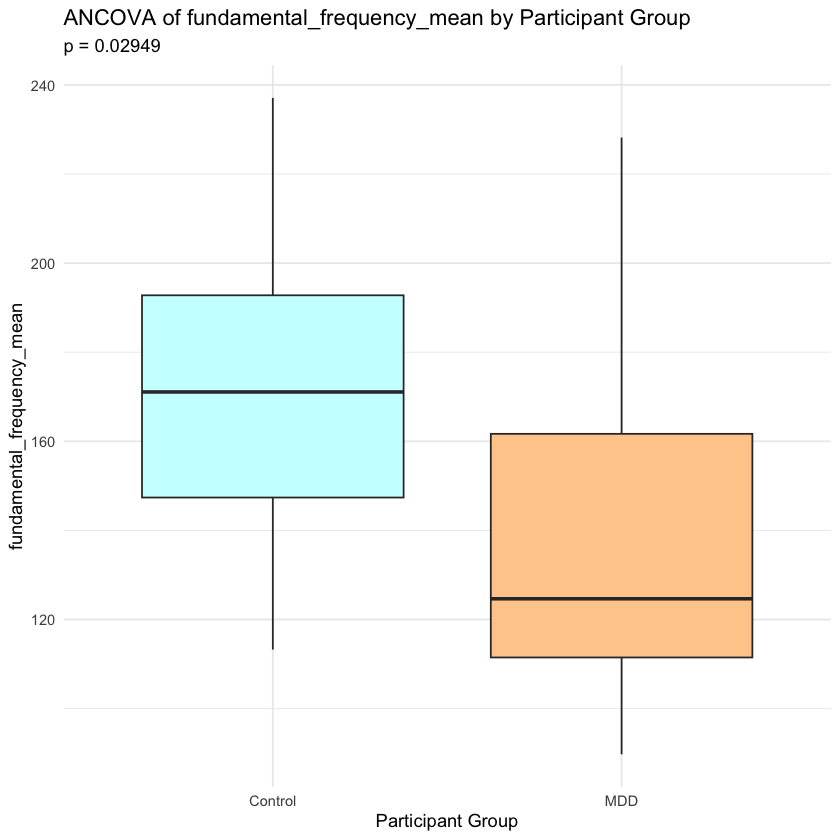

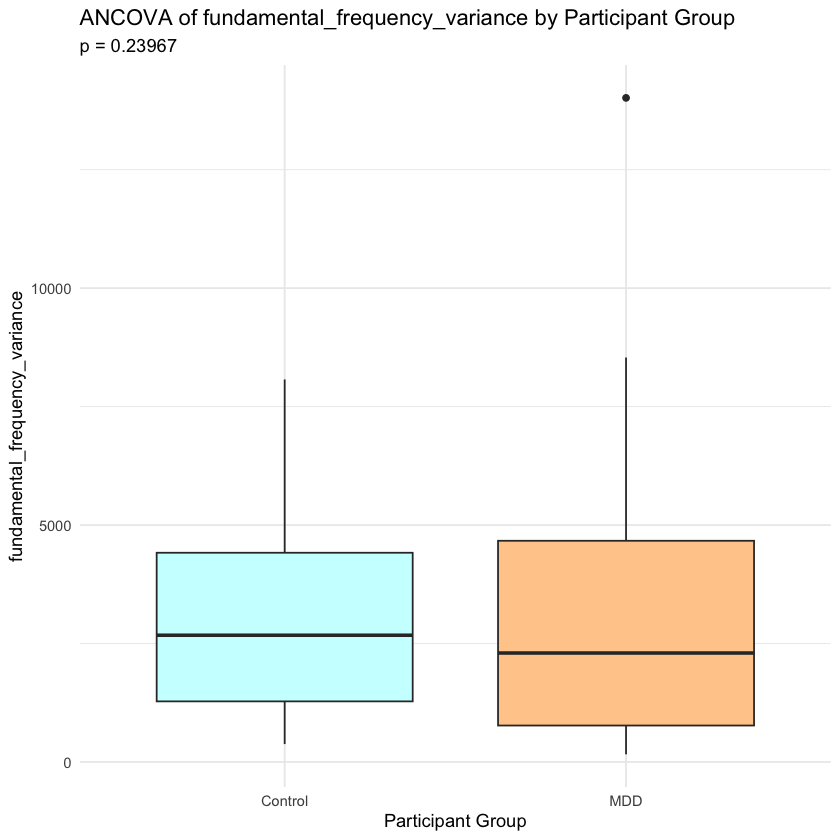

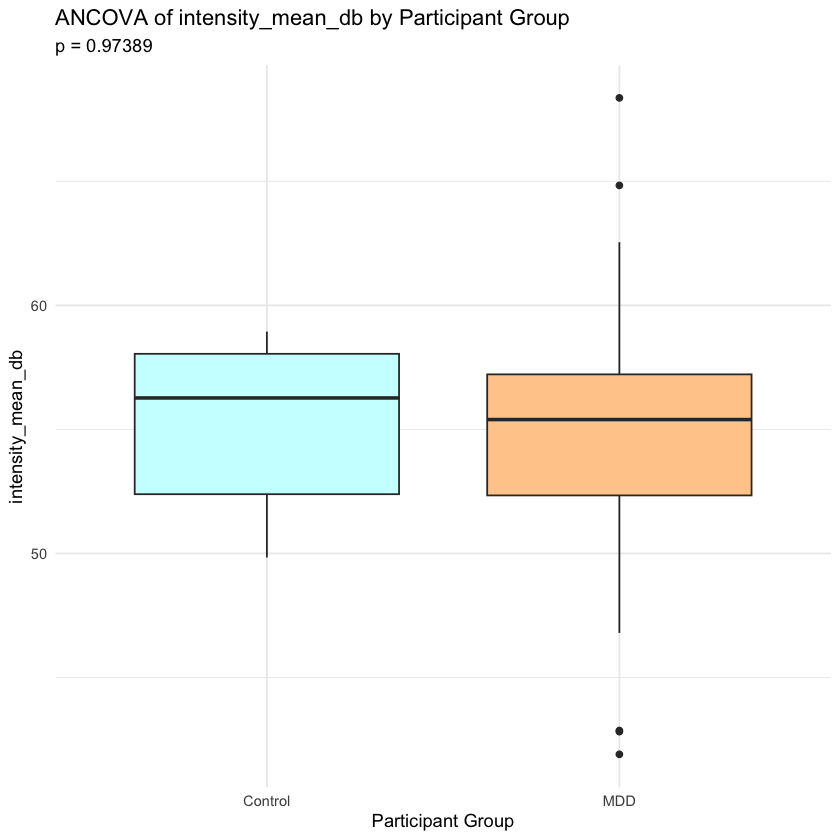

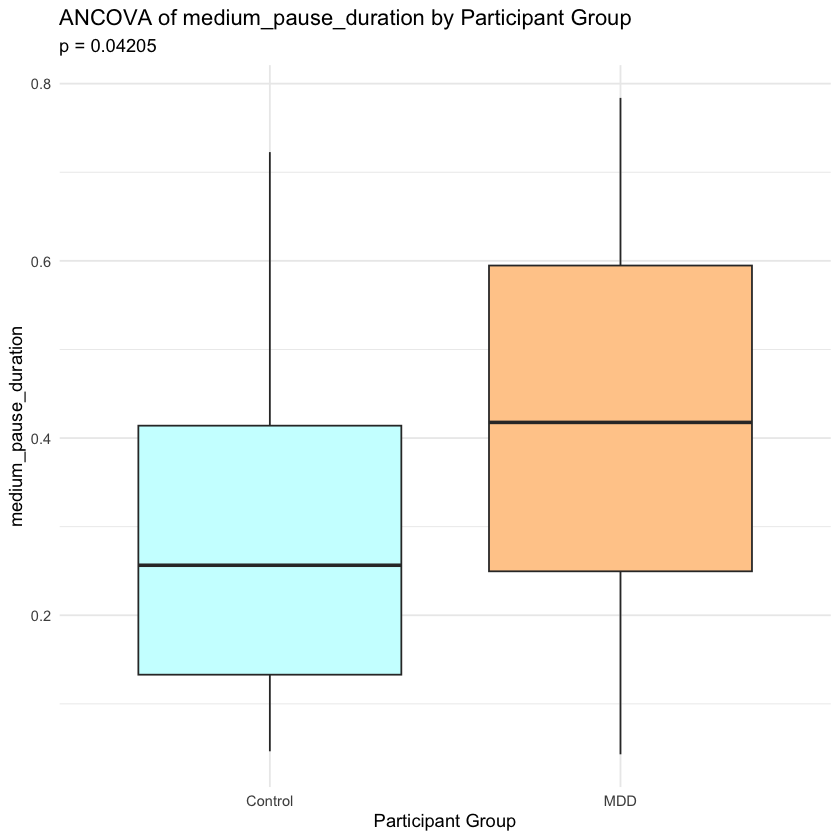

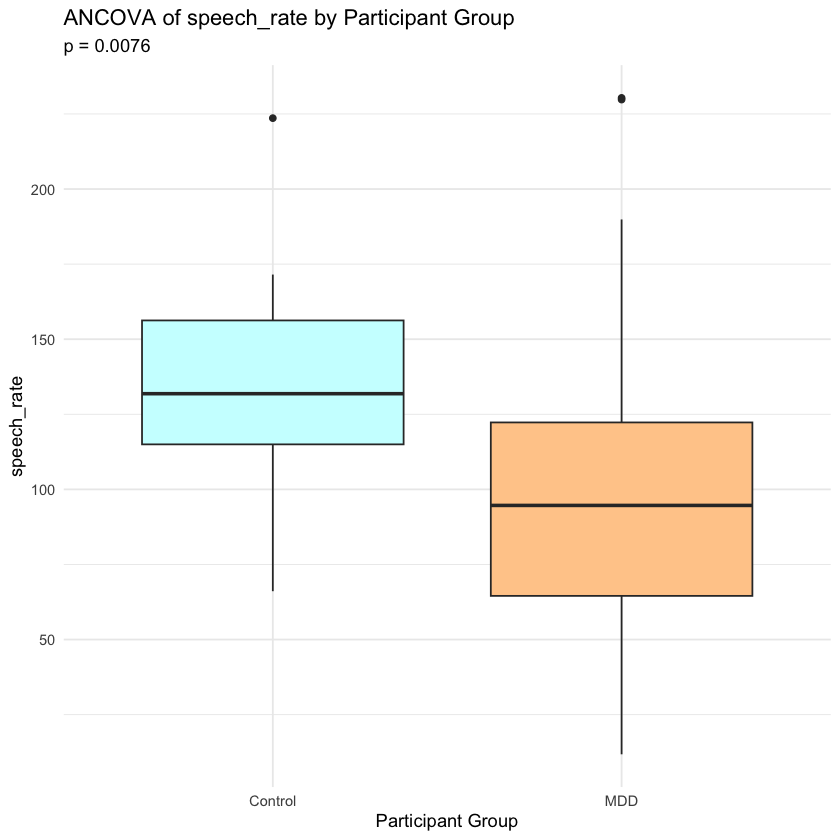

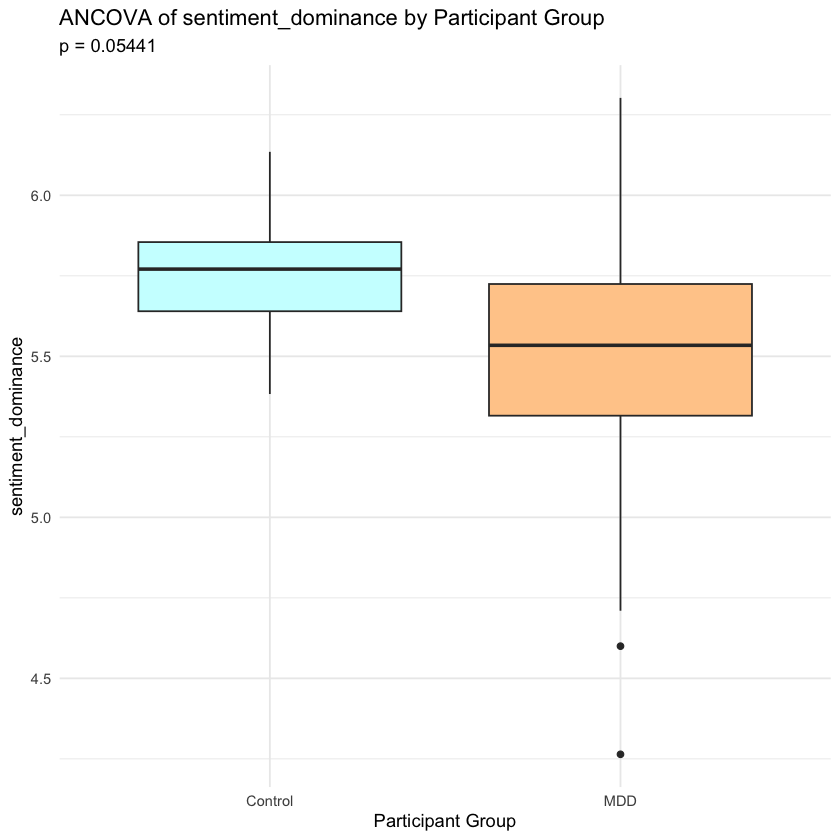

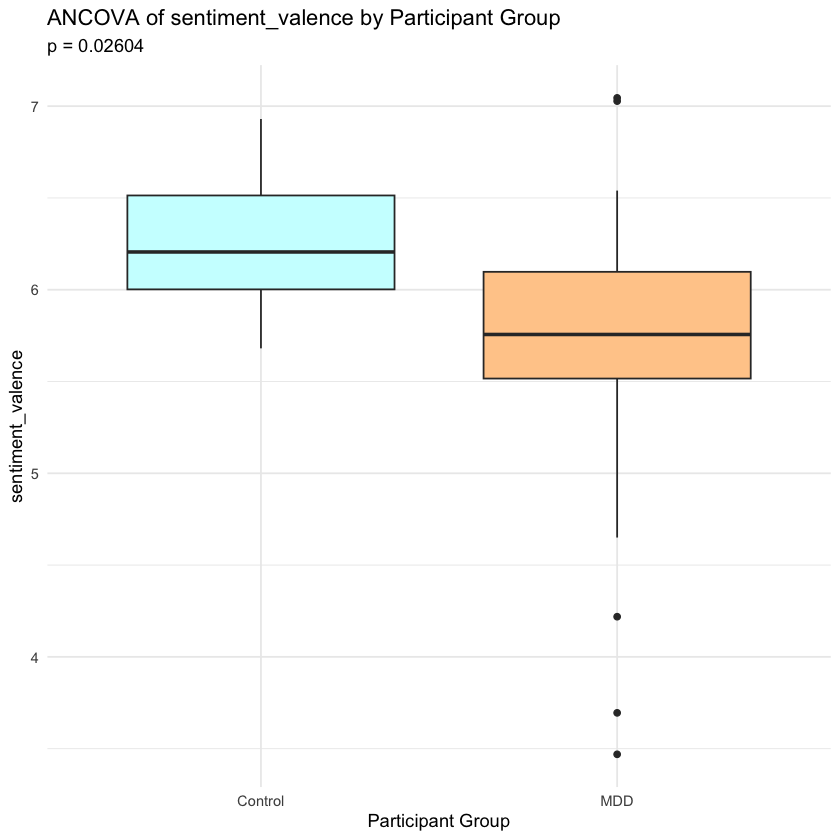

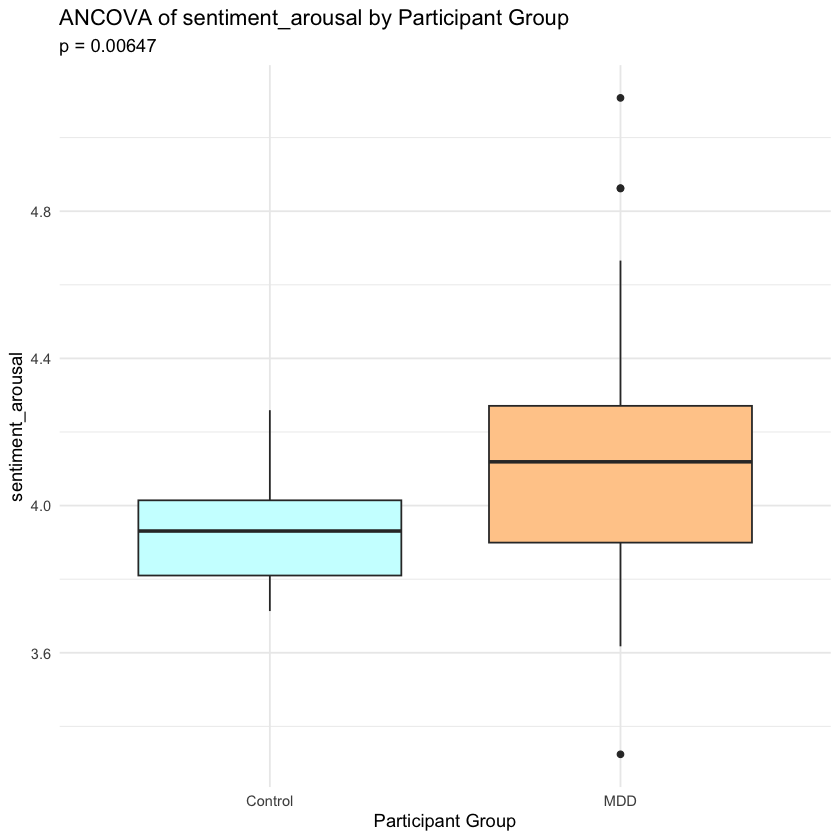

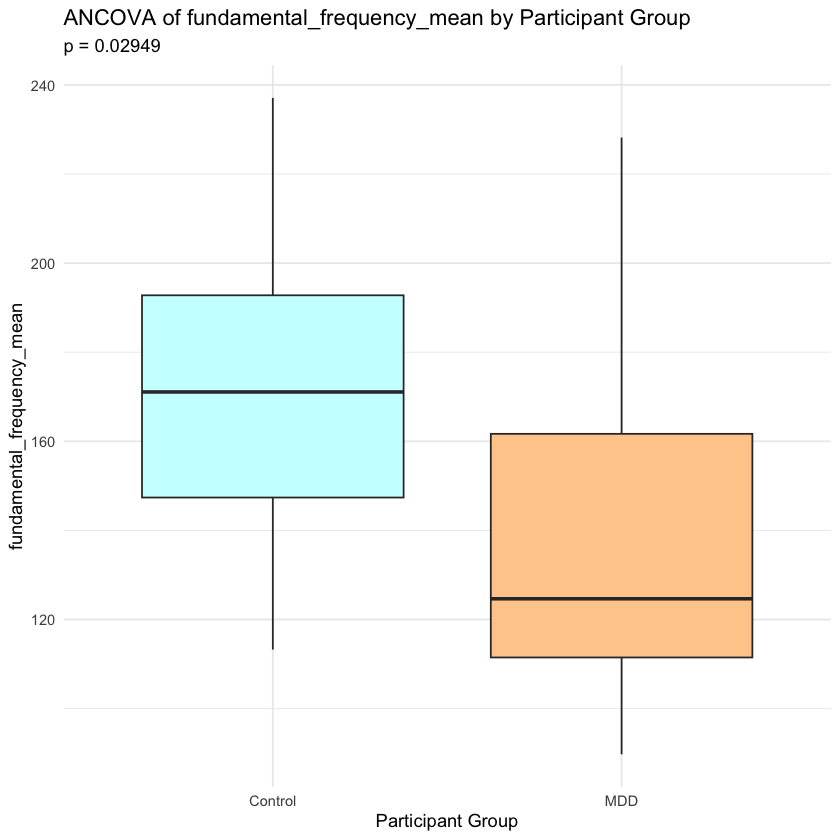

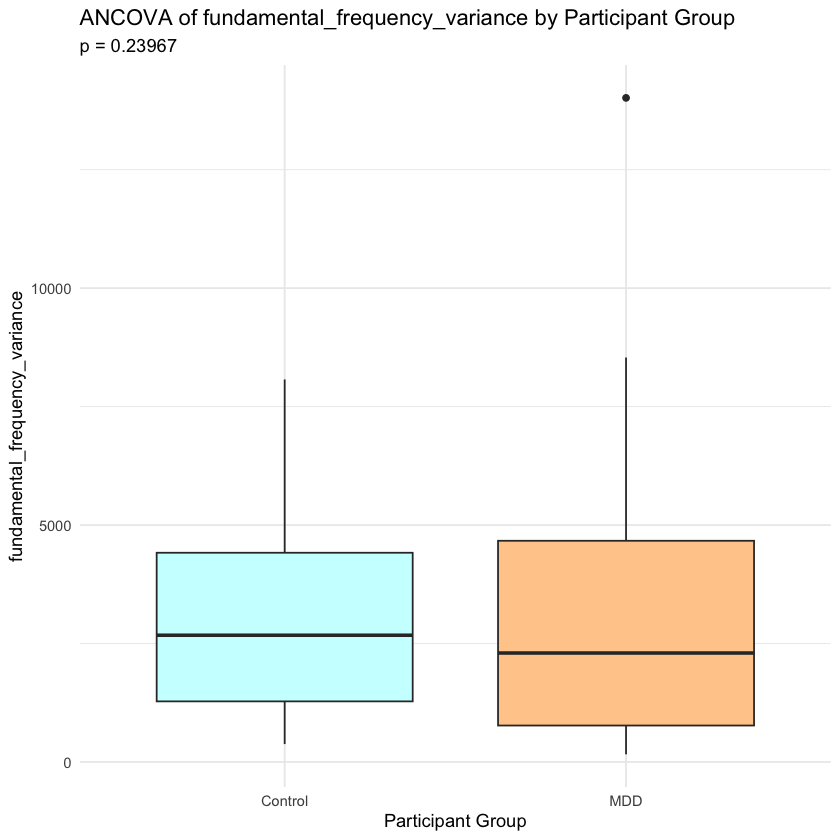

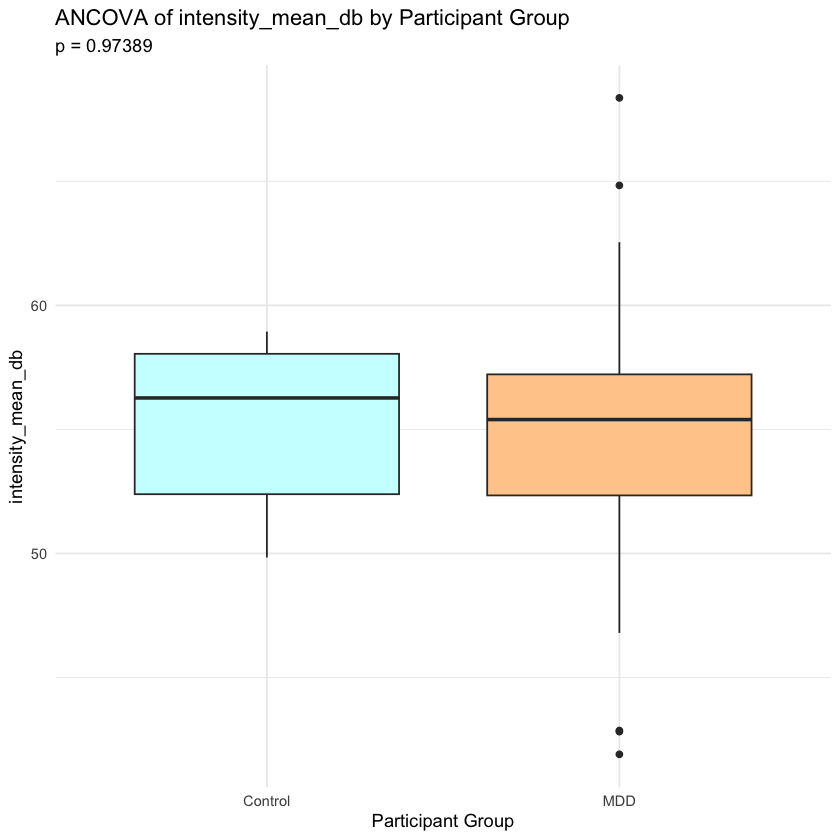

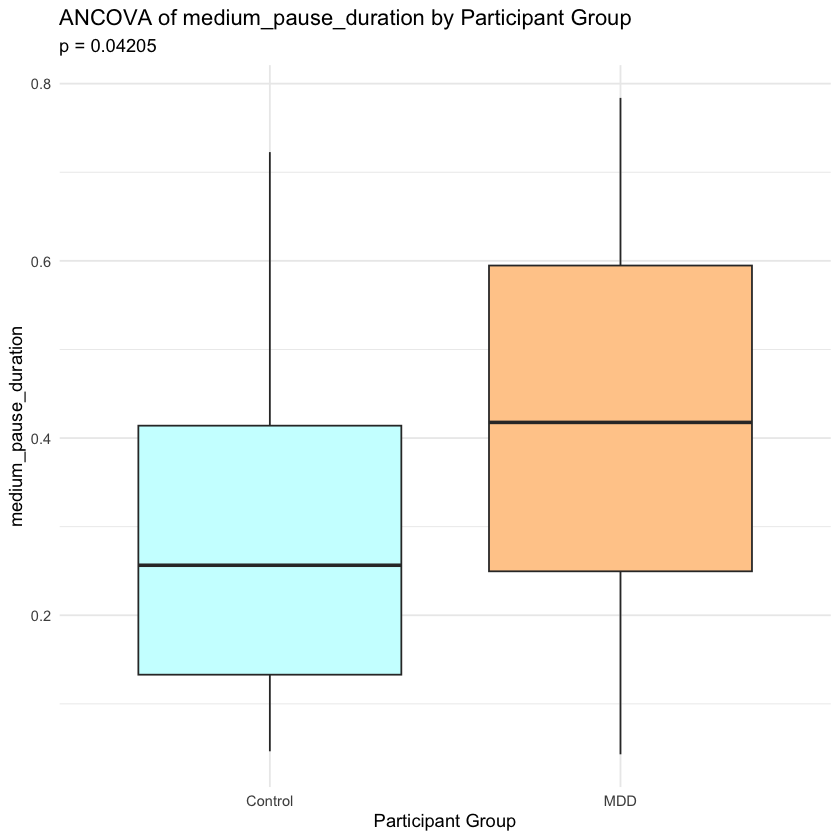

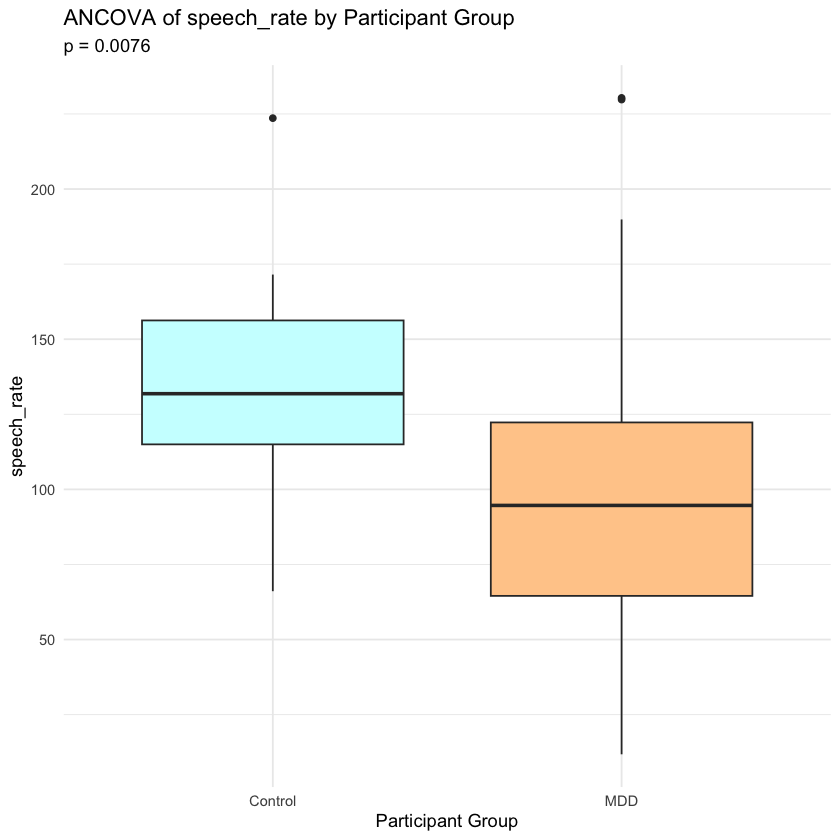

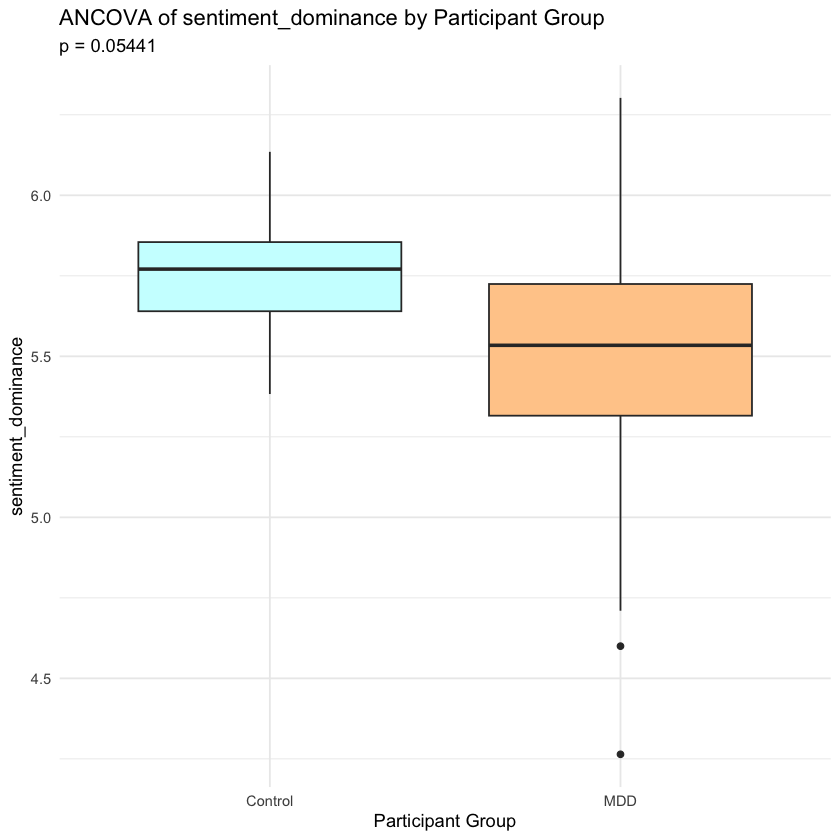

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


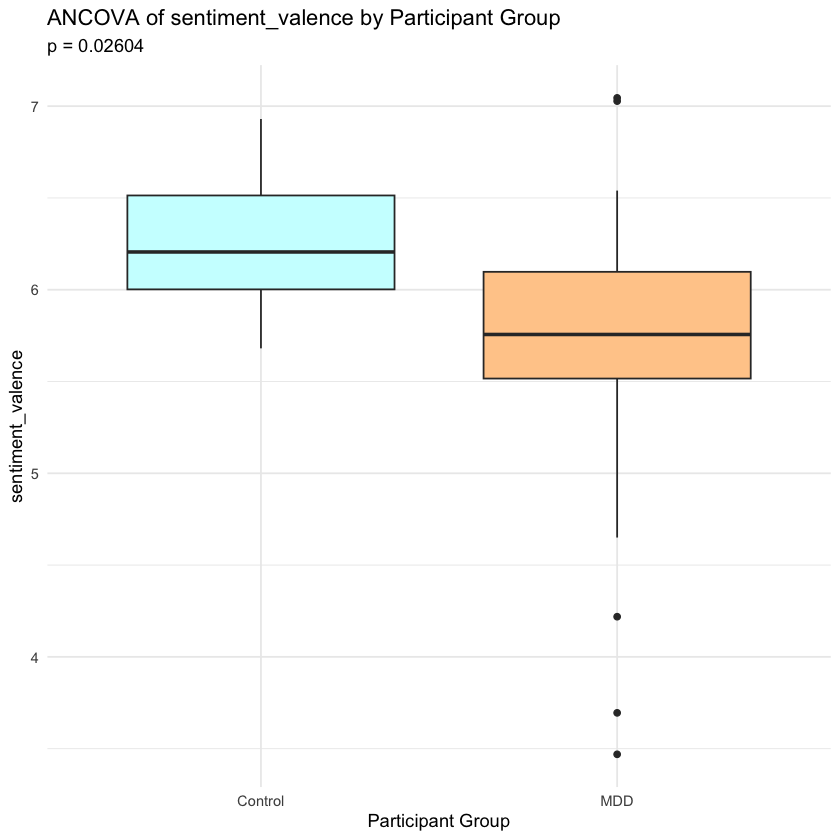

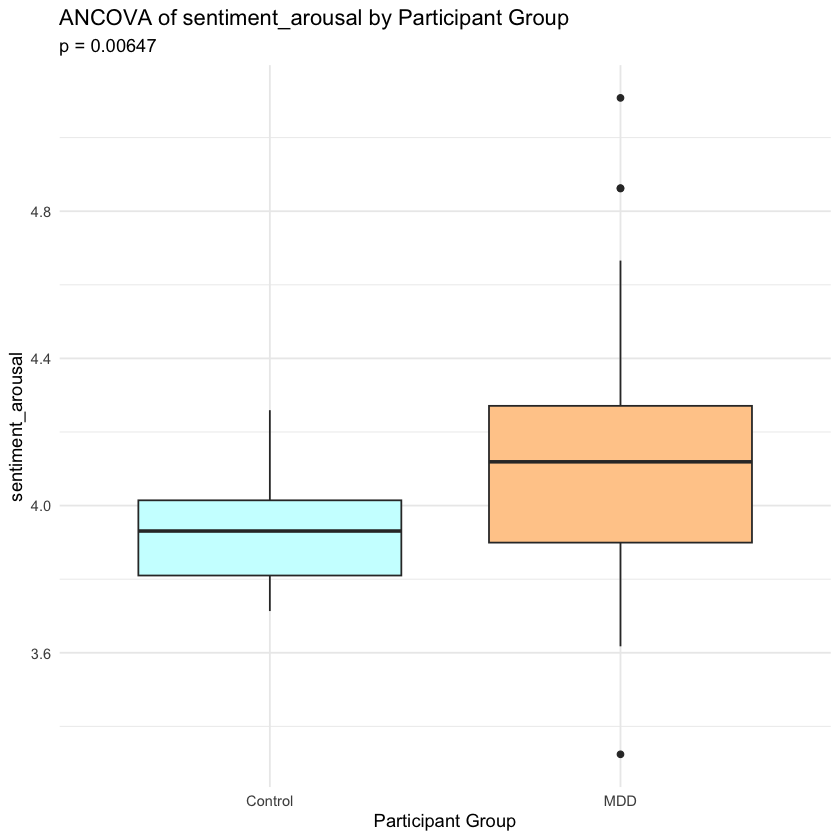

In [57]:
library(ggplot2)
library(dplyr)
library(car)

covariates <- c("sex", "age_learned_english", "age_screening")

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)
p_values_ancovas <- numeric(length = length(speech_variables))

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")


# Loop through each speech variable
for (i in seq_along(speech_variables)) {
    s <- speech_variables[i]
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    filtered_data <- filtered_data[filtered_data$participant_group %in% c("MDD", "Control"),]

    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[2]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[6]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)

    p_values_ancovas[i] <- p_value

    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))
    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = "participant_group", y = s, fill = "participant_group")) +
            geom_boxplot() +
            labs(title = paste("ANCOVA of", s, "by Participant Group"),
                 subtitle = p_label,
                 x = "Participant Group", y = s) +
            theme_minimal() +
            scale_fill_manual(values = c("#CCFFFF", "#FFCC99")) +
            theme(legend.position = "none")
    
    plots[[plot_name]] <- plot
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "DBSFUS_ANCOVA_summary_statistics.csv", row.names = FALSE)


Correction for multiple comparisons

In [44]:
p_values_ancovas <- ancova_stats_df$Pr_F
adjusted_p_values <- p.adjust(p_values_ancovas, method = "BH")
# Display the original and adjusted p-values
data.frame(Original_P_Value = p_values_ancovas, Adjusted_P_Value = adjusted_p_values)

Original_P_Value,Adjusted_P_Value
<dbl>,<dbl>
0.029488844,0.05897769
0.239673747,0.27391285
0.973890344,0.97389034
0.042054125,0.06728660
0.007595979,0.03038391
0.054409563,0.07254608
0.026041949,0.05897769
0.006465883,0.03038391


ANCOVAS with interaction term

$fundamental_frequency_mean
Anova Table (Type III tests)

Response: fundamental_frequency_mean
                      Sum Sq Df  F value    Pr(>F)    
(Intercept)           151849  1 207.7589 < 2.2e-16 ***
participant_group       2995  1   4.0974  0.047907 *  
sex                     6891  1   9.4286  0.003341 ** 
age_learned_english       72  1   0.0991  0.754105    
age_screening             20  1   0.0279  0.868012    
participant_group:sex     17  1   0.0238  0.878066    
Residuals              39468 54                       
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

$fundamental_frequency_variance
Anova Table (Type III tests)

Response: fundamental_frequency_variance
                         Sum Sq Df F value   Pr(>F)   
(Intercept)            56383892  1  9.1977 0.003719 **
participant_group      16141704  1  2.6331 0.110480   
sex                     2174824  1  0.3548 0.553914   
age_learned_english       69140  1  0.0113 0.915817   
age_screening      

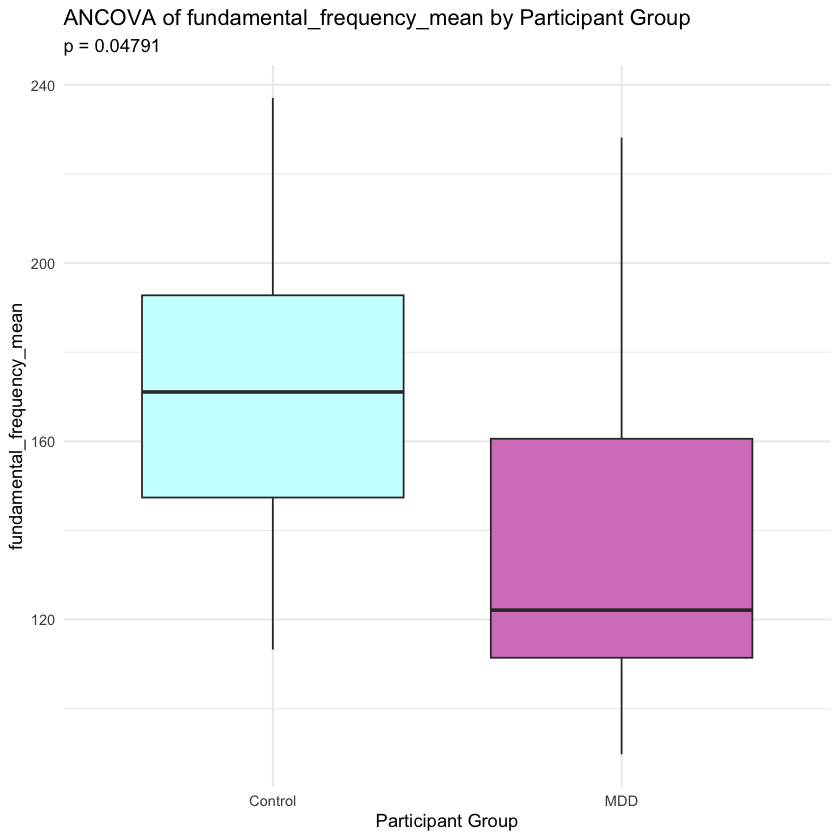


$intensity_mean_db_ANCOVA_plot


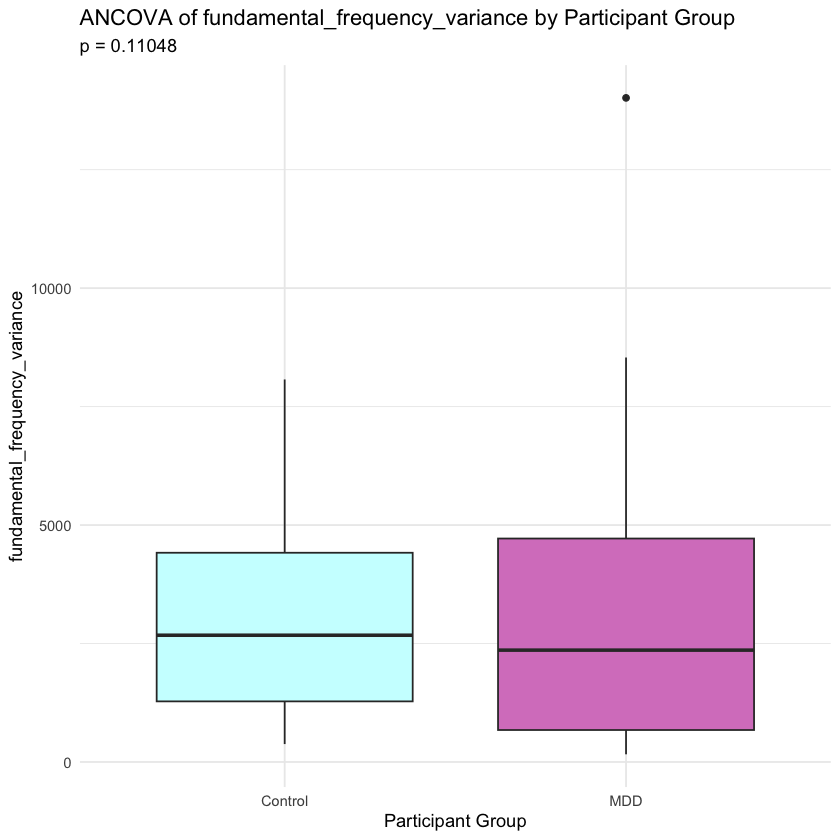


$medium_pause_duration_ANCOVA_plot


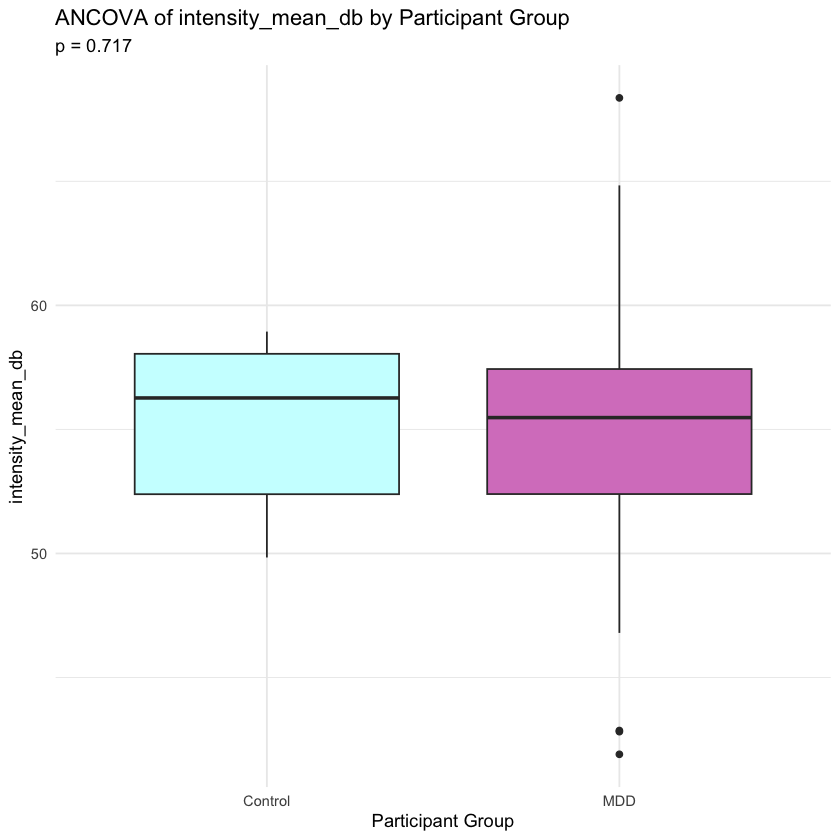


$speech_rate_ANCOVA_plot


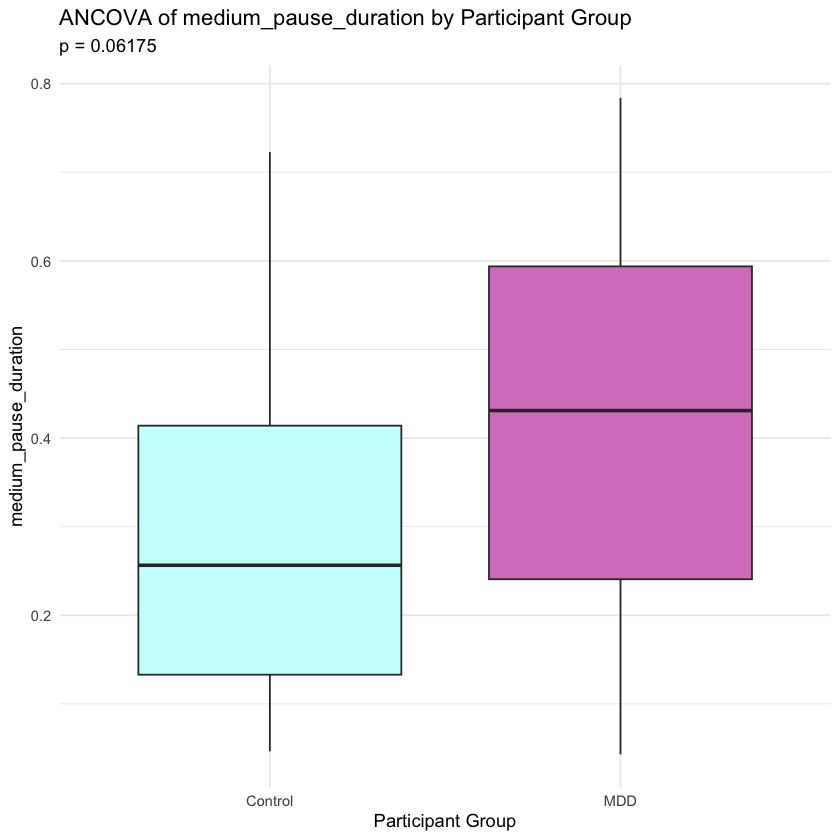


$sentiment_dominance_ANCOVA_plot


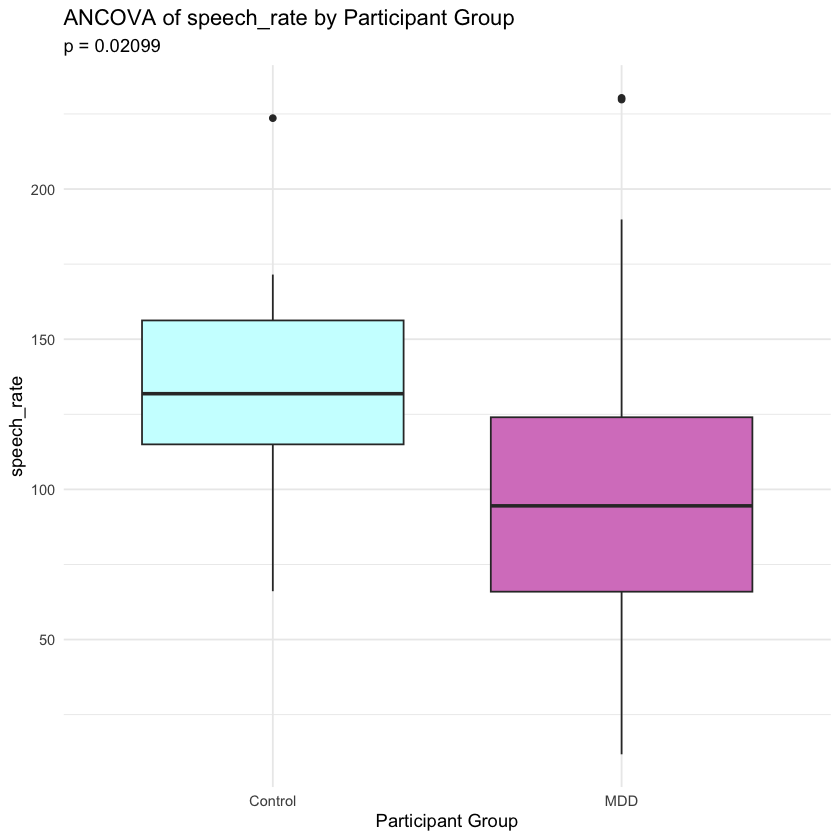


$sentiment_valence_ANCOVA_plot


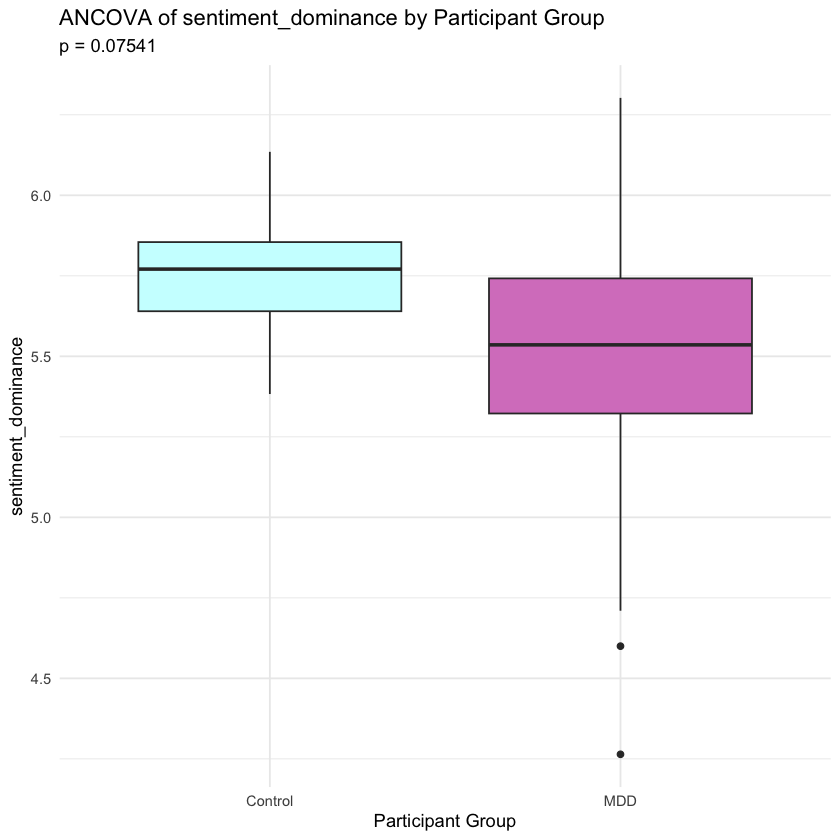


$sentiment_arousal_ANCOVA_plot


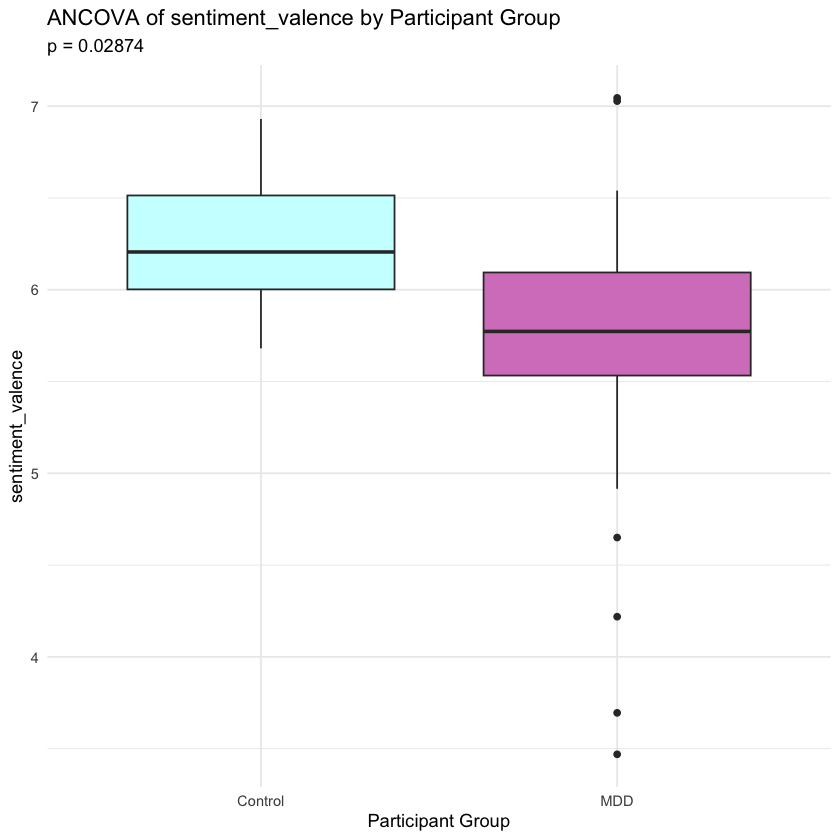

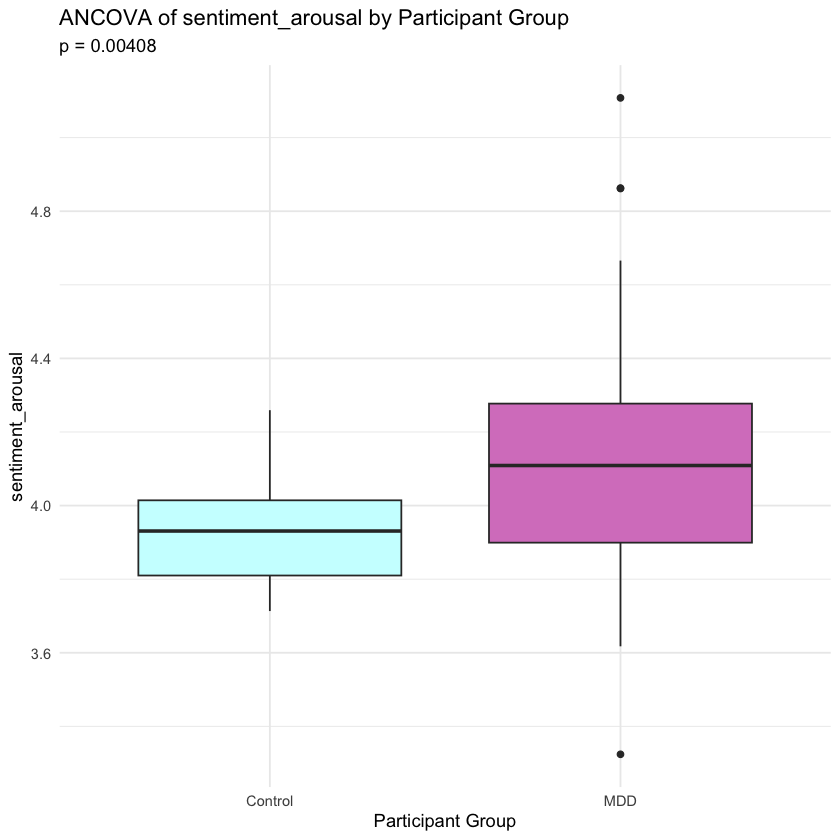

In [45]:
covariates <- c("age_learned_english", "age_screening")  # Removed 'sex' as it will be used in the interaction term
plots <- list()
results_ancova <- list()

WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

for (s in speech_variables) {
    # Filter out data without an assigned participant group
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]

    # Fit the linear model on the filtered data with interaction term
    formula <- as.formula(paste(s, "~ participant_group * sex +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)

    # Perform ANCOVA
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova

    # Extract p-value for participant_group effect
    p_value <- ancova$`Pr(>F)`[2]  # Assuming participant_group is the second term in the model

    # Formatting p-value for the plot
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    # Plotting
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = "participant_group", y = s, fill = "participant_group")) +
            geom_boxplot() +
            labs(title = paste("ANCOVA of", s, "by Participant Group"),
                 subtitle = p_label,
                 x = "Participant Group", y = s) +
            theme_minimal() +
            scale_fill_manual(values = c("#CCFFFF", "#D783C6")) +
            theme(legend.position = "none")

    # Save the plot
    plots[[plot_name]] <- plot
}

# Print results and display plots
print(results_ancova)
print(plots)


Sample size

In [58]:
library(dplyr)

# First, filter for unique participant IDs based on participant_external_id
unique_participants <- WL_demo_psych %>%
  distinct(participant_external_id, .keep_all = TRUE)

# Then, calculate mean and SD of age for each participant group
age_stats <- unique_participants %>%
  group_by(participant_group) %>%
  summarise(
    mean_age = mean(age_screening, na.rm = TRUE),
    sd_age = sd(age_screening, na.rm = TRUE),
    .groups = 'drop' # Optionally drop grouping structure after summarise
  )


# Assuming unique_participants contains only unique IDs as prepared previously
sex_distribution <- unique_participants %>%
  group_by(participant_group, sex) %>%
  summarise(
    count = n(),
    .groups = 'drop'
  ) %>%
  group_by(participant_group) %>%
  mutate(
    percentage = count / sum(count) * 100
  )

# Adjusting previous code for unique IDs and NA participants
# Count unique IDs for each combination of sex and participant group
unique_counts <- WL_demo_psych %>%
  group_by(participant_group, sex) %>%
  summarise(unique_ids = n_distinct(participant_external_id), .groups = 'drop')

# Filter rows where both sex and participant_group are NA
na_participants <- WL_demo_psych %>%
  filter(is.na(sex) | is.na(participant_group)) %>%
  distinct(participant_external_id)

# Print the results
print(age_stats)
print(sex_distribution)
print(unique_counts)
print(na_participants)


# A tibble: 3 x 3
  participant_group mean_age sd_age
  <fct>                <dbl>  <dbl>
1 Control               46.6   19.5
2 MDD                   44.0   14.3
3 OCD                  NaN     NA  
# A tibble: 6 x 4
# Groups:   participant_group [3]
  participant_group sex   count percentage
  <fct>             <chr> <int>      <dbl>
1 Control           F        13      81.2 
2 Control           M         3      18.8 
3 MDD               F        22      41.5 
4 MDD               M        28      52.8 
5 MDD               NA        3       5.66
6 OCD               NA        9     100   
# A tibble: 6 x 3
  participant_group sex   unique_ids
  <fct>             <chr>      <int>
1 Control           F             13
2 Control           M              3
3 MDD               F             22
4 MDD               M             28
5 MDD               NA             3
6 OCD               NA             9
# A tibble: 12 x 1
   participant_external_id
   <chr>                  
 1 MFB08           